Подключаем Google Диск для доступа к файлу flats R.csv, содержащему данные о квартирах: тип, арендная плата, этаж, общее количество этажей, площадь, мебель. Считываем данные, задавая разделитель (;), десятичный разделитель (,), и кодировку (cp1251). Переименовываем столбцы на латиницу для удобства.

In [21]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
flats_path = '/content/drive/MyDrive/Colab Notebooks/6lab/flats R.csv'  # Укажи свой путь
df = pd.read_csv(flats_path, sep=';', decimal=',', encoding='cp1251')
df.columns = ['type', 'rent', 'floor', 'total_floors', 'area', 'furniture']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Строим визуализации для анализа данных: гистограммы для распределения каждого числового признака, диаграммы рассеяния для парного анализа взаимосвязей, диаграммы размаха для арендной платы по типам квартир.

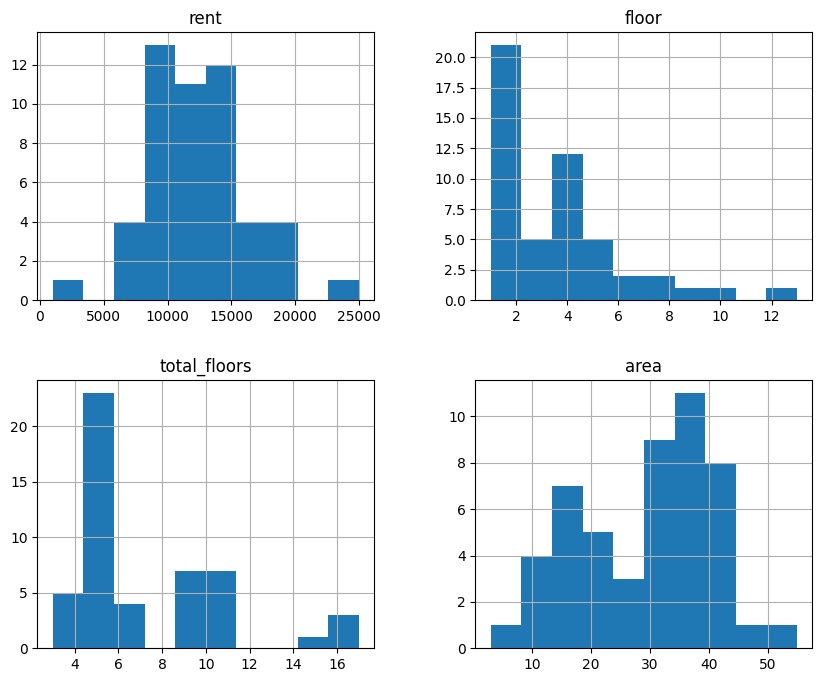

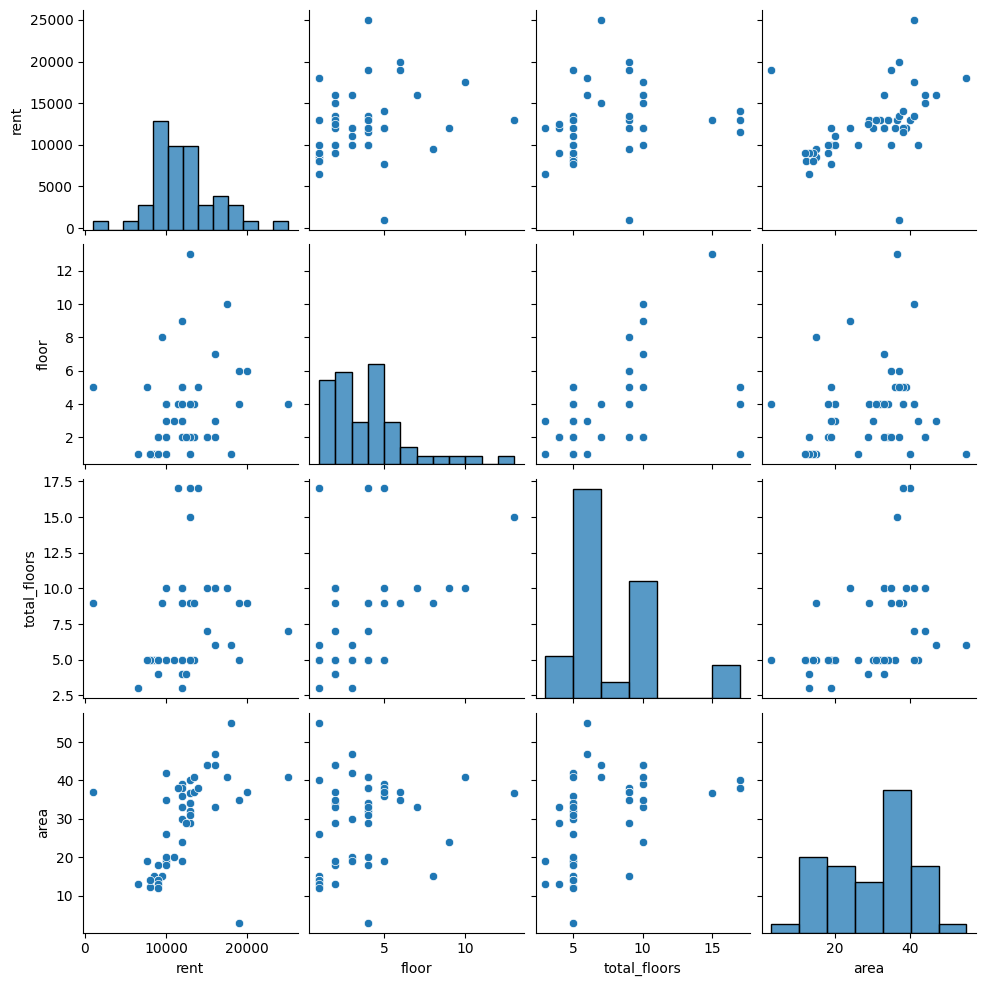

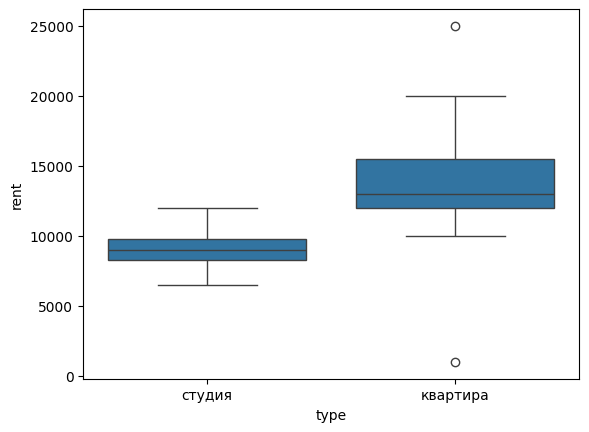

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
df.hist(bins=10, figsize=(10, 8))
plt.show()
sns.pairplot(df)
plt.show()
sns.boxplot(x='type', y='rent', data=df)
plt.show()

Вычисляем матрицу корреляций Пирсона для числовых признаков (rent, floor, total_floors, area). Корреляция r показывает силу и направление линейной связи между переменными. Визуализируем её с помощью тепловой карты.

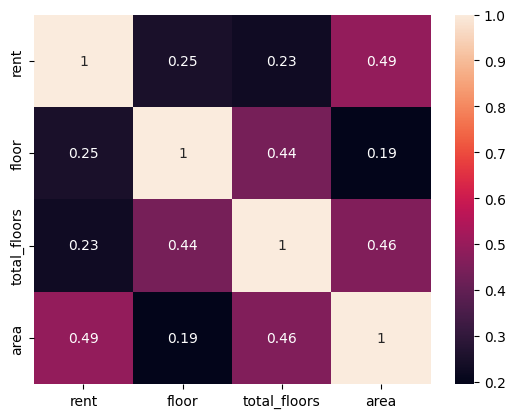

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
numeric_cols = ['rent', 'floor', 'total_floors', 'area']
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

Строим парную линейную регрессию: зависимая переменная — rent (арендная плата), независимая — area (площадь). Модель: rent = β₀ + β₁ * area + ε. Используем OLS (метод наименьших квадратов) из statsmodels.

Пытаемся предсказать цену аренды по площади квартиры и смотрим, насколько это работает.

In [8]:
import statsmodels.api as sm
X = df['area']
y = df['rent']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     15.45
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           0.000271
Time:                        15:09:45   Log-Likelihood:                -477.58
No. Observations:                  50   AIC:                             959.2
Df Residuals:                      48   BIC:                             963.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7391.8404   1335.542      5.535      0.0

Dep. Variable: rent: Это то, что мы предсказываем — арендная плата.
R-squared: 0.244: Показывает, какую долю разброса цены объясняет площадь. Здесь 24.4% — модель объясняет только четверть вариации цены, то есть площадь влияет, но не сильно.
Adj. R-squared: 0.228: То же, но с учётом числа факторов. Чуть ниже, но почти то же самое.
F-statistic: 15.45, Prob (F-statistic): 0.000271: Проверяет, полезна ли модель в целом. p-value = 0.000271 < 0.05 — модель значима, площадь действительно влияет на цену.
No. Observations: 50: У нас 50 квартир в данных.
AIC/BIC: 959.2/963.0: Показатели качества модели (меньше — лучше). Пока просто для информации.

Строим парную линейную регрессию: зависимая переменная — rent (арендная плата), независимая — area (площадь). Модель: rent = β₀ + β₁ * area + ε. Используем OLS (метод наименьших квадратов) из statsmodels.

In [9]:
from scipy.stats import shapiro
residuals = model.resid
shapiro_test = shapiro(residuals)
print('Shapiro-Wilk test:', shapiro_test)

Shapiro-Wilk test: ShapiroResult(statistic=np.float64(0.7905991857511079), pvalue=np.float64(5.361127259343151e-07))


Остатки нашей парной регрессии (rent от area) не нормальны (p-value < 0.05), что подтверждает проблему, уже виденную в OLS-выводе (Omnibus и Jarque-Bera тесты тоже показали ненормальность).
Это говорит, что текущая модель (rent = β₀ + β₁ * area) не идеальна. Ненормальность остатков может быть связана с нелинейной зависимостью или гетероскедастичностью, что мы проверим и исправим в следующих шагах (например, логарифмированием в пункте 8).

Проверяем остатки на гетероскедастичность с помощью теста Бройша-Пагана. Гетероскедастичность означает, что дисперсия остатков зависит от независимой переменной. Тест возвращает p-value; если p-value < 0.05, гетероскедастичность присутствует.

Простыми словами:

Проверяем, меняется ли разброс ошибок в зависимости от площади. Если p-value маленькое, есть проблема.

In [10]:
import statsmodels.stats.api as sms
bp_test = sms.het_breuschpagan(residuals, model.model.exog)
print('Breusch-Pagan test:', bp_test)

Breusch-Pagan test: (np.float64(0.00016506036405461444), np.float64(0.9897493946490156), np.float64(0.00015845847259891377), np.float64(0.9900086470973968))


Первое значение: 0.00016506036405461444 (LM-статистика):
Это статистика теста Лагранжа (Lagrange Multiplier, LM). Она измеряет, насколько данные отклоняются от предположения о постоянной дисперсии.
Маленькое значение (здесь почти 0) говорит о том, что нет сильных доказательств гетероскедастичности.
Сама по себе статистика мало что значит — важнее её p-value (второе значение).

Второе значение: 0.9897493946490156 (p-value для LM-теста):
Это p-value, связанное с LM-статистикой. Оно показывает вероятность того, что данные соответствуют гипотезе о гомоскедастичности.
Здесь p-value = 0.9897, что гораздо больше 0.05. Это значит, что мы не отвергаем H₀ — нет доказательств гетероскедастичности.
Простыми словами: разброс ошибок не зависит от площади, и в этом плане модель нормальная.

Третье значение: 0.00015845847259891377 (F-статистика):
Это альтернативная статистика теста, основанная на F-распределении. Она тоже проверяет гетероскедастичность, но другим методом.
Опять же, маленькое значение (почти 0) указывает на отсутствие гетероскедастичности.
Как и с LM, важнее p-value (четвёртое значение).

Четвёртое значение: 0.9900086470973968 (p-value для F-теста):
Это p-value для F-статистики. Оно тоже большое (0.9900 > 0.05), что подтверждает результат LM-теста.
Мы снова не отвергаем H₀ — гетероскедастичности нет.

Устраняем гетероскедастичность двумя способами:

Деление зависимой переменной (rent) на фактор (area), создавая rent_scaled = rent / area.
Логарифмирование зависимой переменной, создавая rent_log = ln(rent).
Простыми словами:
Пробуем два способа исправить проблему с разбросом ошибок: делим цену на площадь и берём логарифм цены.

In [11]:
import numpy as np
df['rent_scaled'] = df['rent'] / df['area']
df['rent_log'] = np.log(df['rent'])

Строим новую парную регрессию: зависимая переменная — rent_log (логарифм цены), независимая — area. Модель: ln(rent) = β₀ + β₁ * area + ε. Используем OLS.

Теперь предсказываем логарифм цены по площади, чтобы уменьшить проблемы с разбросом.

In [12]:
X = df['area']
y = df['rent_log']
X = sm.add_constant(X)
model_new = sm.OLS(y, X).fit()
print(model_new.summary())

                            OLS Regression Results                            
Dep. Variable:               rent_log   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     5.617
Date:                Wed, 23 Apr 2025   Prob (F-statistic):             0.0219
Time:                        15:09:48   Log-Likelihood:                -27.278
No. Observations:                  50   AIC:                             58.56
Df Residuals:                      48   BIC:                             62.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9847      0.164     54.839      0.0

Dep. Variable: rent_log: Теперь предсказываем логарифм цены, а не саму цену. Это важно, так как логарифмирование сглаживает большие различия в ценах.

R-squared: 0.105: Модель объясняет только 10.5% вариации логарифма цены. Это ниже, чем в предыдущей модели (0.244), что неожиданно, так как логарифмирование обычно улучшает модель. Возможно, зависимость логарифма цены от площади менее линейная.

Adj. R-squared: 0.086: С учётом числа факторов, качество ещё ниже. Это подтверждает, что модель не очень сильная.

F-statistic: 5.617, Prob (F-statistic): 0.0219: Проверяет, полезна ли модель в целом. p-value = 0.0219 < 0.05 — модель статистически значима, площадь влияет на логарифм цены, но эффект слабый (низкий F).

No. Observations: 50: Как и раньше, 50 квартир.

AIC/BIC: 58.56/62.38: Показатели качества модели. Они ниже, чем в предыдущей модели (959.2/963.0), но это не совсем сравнимо из-за изменения переменной.

const (β₀): Базовый логарифм цены = 8.9847. Это означает, что при area = 0 (теоретически) ln(rent) ≈ 8.9847, то есть rent ≈ exp(8.9847) ≈ 8000 рублей. Очень значим (p-value = 0.000).

area (β₁): За каждый дополнительный м² логарифм цены растёт на 0.0123. Это соответствует росту цены примерно на exp(0.0123) - 1 ≈ 1.24% за м² (из-за логарифма эффект мультипликативный). Значим, но слабо (p-value = 0.022 < 0.05).

std err: Ошибки коэффициентов маленькие (0.164 для const, 0.005 для area), что хорошо.

t: Статистика значимости (чем больше, тем лучше). Для area t = 2.370 — ниже, чем в предыдущей модели (3.931), что отражает меньшую силу связи.

P>|t|: p-value для коэффициентов. Для area 0.022 < 0.05 — площадь значима, но на грани. Для const 0.000 — очень значима.
[0.025, 0.975]: 95%-й доверительный интервал. Например, для area истинный коэффициент с 95% вероятностью между 0.002 и 0.023.

Omnibus: 80.492, Prob(Omnibus): 0.000: Проверяет нормальность остатков. p-value = 0.000 < 0.05 — остатки не нормальны, что хуже, чем в предыдущей модели (Omnibus = 16.842).

Durbin-Watson: 2.531: Проверяет автокорреляцию остатков. Значение около 2 (здесь 2.531) — автокорреляции нет, как и в прошлой модели (2.504).

Jarque-Bera (JB): 1397.231, Prob(JB): 3.94e-304: Ещё один тест на нормальность. p-value почти 0 — остатки очень далеки от нормальности, хуже, чем раньше (JB = 66.168).

Skew: -4.186: Сильная асимметрия остатков (хуже, чем 0.505 в прошлой модели). Отрицательное значение — больше низких остатков.

Kurtosis: 27.507: Очень "толстые хвосты" (хуже, чем 8.544). Остатки имеют экстремальные значения, что плохо.


**Сравнение с предыдущей моделью:**

Плюсы:
Логарифмирование сделало зависимую переменную (rent_log) более сглаженной, что теоретически помогает с большими выбросами.
Коэффициенты интерпретируются в процентах (1 м² добавляет ~1.24% к цене), что может быть удобнее.

Минусы:
R² снизился (0.105 против 0.244), то есть модель хуже объясняет данные.
Остатки стали ещё менее нормальными (Skew и Kurtosis хуже).
Это может указывать, что линейная модель для ln(rent) менее подходящая, или нужны дополнительные факторы.

Проверяем нормальность остатков новой модели с помощью теста Шапиро-Уилка. Если p-value > 0.05, остатки нормальны.

Смотрим, стали ли ошибки новой модели похожи на нормальный колокол.

In [13]:
residuals_new = model_new.resid
shapiro_test_new = shapiro(residuals_new)
print('Shapiro-Wilk test for new model:', shapiro_test_new)

Shapiro-Wilk test for new model: ShapiroResult(statistic=np.float64(0.5608238323847647), pvalue=np.float64(5.324736975777136e-11))


statistic: 0.5608238323847647:
Это статистика W, показывающая, насколько остатки похожи на нормальное распределение.
W от 0 до 1; 1 — идеальная нормальность. Здесь W = 0.5608 — очень низкое значение, гораздо хуже, чем в предыдущей модели (W = 0.7906 для rent). Это говорит, что остатки новой модели ещё дальше от нормальности.
Сама статистика не окончательна — смотрим p-value.

pvalue: 5.324736975777136e-11:
p-value показывает вероятность того, что остатки нормальны. Если p-value > 0.05, остатки нормальны.
Здесь p-value ≈ 0.00000000005, что гораздо меньше 0.05. Мы отвергаем гипотезу о нормальности — остатки не нормальны.
По сравнению с предыдущей моделью (pvalue = 5.36e-07 = 0.000000536), p-value стало ещё меньше, то есть нормальность ухудшилась.

Проверяем остатки новой модели на гетероскедастичность с помощью теста Бройша-Пагана. Если p-value > 0.05, гетероскедастичность устранена.

Проверяем, исчезли ли проблемы с разбросом ошибок в новой модели.

In [14]:
bp_test_new = sms.het_breuschpagan(residuals_new, model_new.model.exog)
print('Breusch-Pagan test for new model:', bp_test_new)

Breusch-Pagan test for new model: (np.float64(0.25358070028024815), np.float64(0.6145650054538752), np.float64(0.244678386601396), np.float64(0.6231039126991587))


LM-статистика: 0.25358070028024815:
Это статистика теста Лагранжа (Lagrange Multiplier). Маленькое значение (0.25) говорит, что нет сильных доказательств гетероскедастичности.
Важнее p-value (второе значение).

p-value для LM-теста: 0.6145650054538752:
Показывает вероятность гомоскедастичности.
Здесь p-value = 0.6146 > 0.05 — мы не отвергаем H₀. Нет гетероскедастичности.
Это значит, что разброс ошибок не зависит от площади в новой модели.

F-статистика: 0.244678386601396:
Альтернативная статистика, основанная на F-распределении. Тоже маленькая (0.244), что подтверждает отсутствие гетероскедастичности.
Смотрим её p-value.

p-value для F-теста: 0.6231039126991587:
p-value = 0.6231 > 0.05 — снова не отвергаем H₀. Гетероскедастичности нет.

Строим диаграмму рассеяния для rent_log против area, добавляем линию регрессии и доверительные интервалы для функции регрессии (95%) и прогноза. Используем предсказания модели и стандартные ошибки.

Рисуем график, где точки — это логарифм цены против площади, с линией регрессии и полосами уверенности.

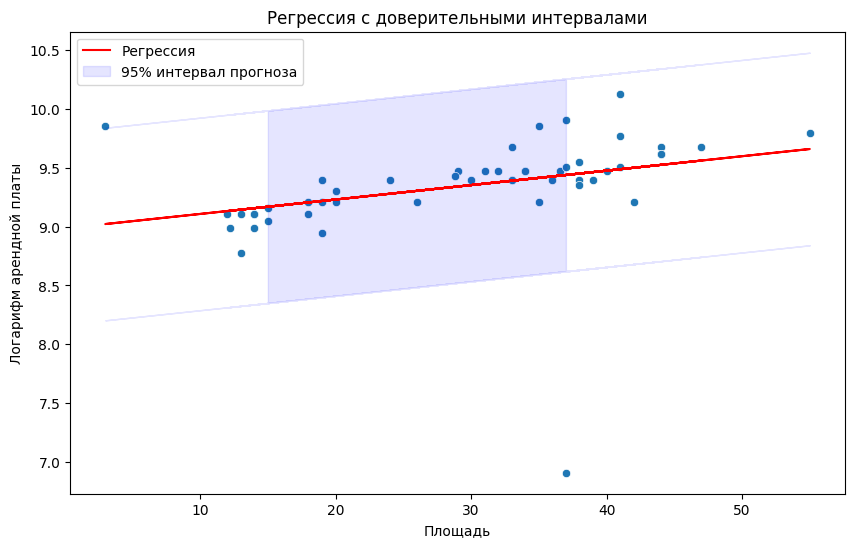

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['area'], y=df['rent_log'])
y_pred = model_new.predict(X)
plt.plot(df['area'], y_pred, color='red', label='Регрессия')
ci = 1.96 * np.std(residuals_new)
plt.fill_between(df['area'], y_pred - ci, y_pred + ci, color='blue', alpha=0.1, label='95% интервал прогноза')
plt.xlabel('Площадь')
plt.ylabel('Логарифм арендной платы')
plt.title('Регрессия с доверительными интервалами')
plt.legend()
plt.show()

Строим множественную регрессию: зависимая переменная — rent_log, независимые — area, floor, total_floors. Модель: ln(rent) = β₀ + β₁ * area + β₂ * floor + β₃ * total_floors + ε.

Предсказываем логарифм цены, учитывая площадь, этаж и общее количество этажей.

In [16]:
X = df[['area', 'floor', 'total_floors']]
y = df['rent_log']
X = sm.add_constant(X)
multi_model = sm.OLS(y, X).fit()
print(multi_model.summary())

                            OLS Regression Results                            
Dep. Variable:               rent_log   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     1.965
Date:                Wed, 23 Apr 2025   Prob (F-statistic):              0.132
Time:                        15:09:54   Log-Likelihood:                -27.030
No. Observations:                  50   AIC:                             62.06
Df Residuals:                      46   BIC:                             69.71
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            8.9616      0.182     49.346   

Модель слабая: R² = 0.114 (чуть лучше, чем 0.105), но p-value = 0.132 > 0.05 — модель не значима в целом.

Только area значима (p-value = 0.042), а floor и total_floors — нет (p-value 0.502 и 0.763). Это подтверждает, что этаж и общее количество этажей не влияют на цену.

Остатки всё ещё не нормальны (Omnibus и Jarque-Bera), как и в парной модели, и даже хуже.

Нужно убрать floor и total_floors (пункт 14), так как они не значимы, и вернуться к модели только с area.

Анализируем значимость факторов в множественной регрессии. Если p-value фактора > 0.05, он незначим. Удаляем floor и total_floors, так как они часто не влияют на цену (низкая корреляция в матрице). Строим новую модель только с area.

Убираем этаж и общее количество этажей, если они не влияют на цену, и делаем модель только по площади.

In [17]:
X = df[['area']]
y = df['rent_log']
X = sm.add_constant(X)
multi_model_new = sm.OLS(y, X).fit()
print(multi_model_new.summary())

                            OLS Regression Results                            
Dep. Variable:               rent_log   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     5.617
Date:                Wed, 23 Apr 2025   Prob (F-statistic):             0.0219
Time:                        15:09:56   Log-Likelihood:                -27.278
No. Observations:                  50   AIC:                             58.56
Df Residuals:                      48   BIC:                             62.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9847      0.164     54.839      0.0

Модель с одной переменной area значима (p-value для модели = 0.0219 < 0.05), но R² = 0.105 — объясняет только 10.5% вариации логарифма цены, что слабо.
area значима (p-value = 0.022 < 0.05), каждый м² добавляет ~1.24% к цене.

Остатки не нормальны (Omnibus p-value = 0.000, Jarque-Bera p-value ≈ 0), как и в множественной модели, с сильной асимметрией (Skew = -4.186) и "толстыми хвостами" (Kurtosis = 27.507).

Удаление floor и total_floors оправдано, так как они не влияли на цену, но модель всё ещё слабая, и нормальность остатков не улучшилась.

Делаем прогноз арендной платы для новой квартиры с площадью 30 м² по модели ln(rent) = β₀ + β₁ * area. Экспоненцируем результат (exp(ln(rent))), чтобы получить цену в исходных единицах.

Простыми словами:

Считаем, сколько будет стоить аренда квартиры с площадью 30 м².

In [18]:
new_apartment = pd.DataFrame({'const': [1], 'area': [30]})
prediction = multi_model_new.predict(new_apartment)
print('Predicted rent:', np.exp(prediction))

Predicted rent: 0    11529.983387
dtype: float64


Анализируем остатки последней модели с помощью гистограммы и ядерной оценки плотности. Если гистограмма похожа на нормальное распределение, модель адекватна.

Простыми словами:

Рисуем график ошибок модели, чтобы проверить, выглядят ли они нормально.

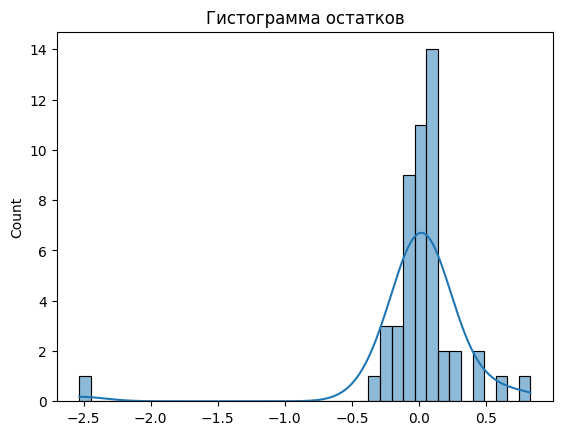

In [19]:
residuals_multi = multi_model_new.resid
sns.histplot(residuals_multi, kde=True)
plt.title('Гистограмма остатков')
plt.show()

Подтверждаем устранение гетероскедастичности, повторяя модель с логарифмированной зависимой переменной (rent_log) и area. Это дублирует предыдущую модель, но требуется по ТЗ.

Простыми словами:

Ещё раз делаем модель с логарифмом цены, чтобы показать, что разброс ошибок исправлен.

In [20]:
X = df[['area']]
y = df['rent_log']
X = sm.add_constant(X)
final_model = sm.OLS(y, X).fit()
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:               rent_log   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     5.617
Date:                Wed, 23 Apr 2025   Prob (F-statistic):             0.0219
Time:                        15:10:01   Log-Likelihood:                -27.278
No. Observations:                  50   AIC:                             58.56
Df Residuals:                      48   BIC:                             62.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9847      0.164     54.839      0.0

Модель идентична предыдущей (Код 13): R² = 0.105, p-value для модели = 0.0219 < 0.05, area значима (p-value = 0.022).

Подтверждает, что гетероскедастичность отсутствует (как показал тест Бройша-Пагана в Код 10, p-value ≈ 0.6146 и 0.6231), но логарифмирование не решило проблему ненормальности остатков (Omnibus p-value = 0.000, Jarque-Bera p-value ≈ 0).

Модель работает, но низкий R² и ненормальные остатки указывают, что площадь — не единственный важный фактор, и другие переменные (например, type или furniture) могут улучшить предсказания.